QPEの簡単な例を実装する

In [29]:
from fractions import Fraction
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.accounts import AccountNotFoundError
from qiskit.visualization import plot_distribution

# ワークブック独自のモジュール
from qc_workbook.utils import operational_backend

In [30]:
n_meas = 3

# 位相測定用のレジスタ
qreg_meas = QuantumRegister(n_meas, name='meas')
# 固有ベクトルを保持するレジスタ
qreg_aux = QuantumRegister(1, name='aux')
# 位相測定の結果が書き出される古典レジスタ
creg_meas = ClassicalRegister(n_meas, name='out')

# 2つの量子レジスタと1つの古典レジスタから量子回路を作る
qc = QuantumCircuit(qreg_meas, qreg_aux, creg_meas)

# それぞれのレジスタを初期化
qc.h(qreg_meas)
qc.x(qreg_aux)

# angle/(2π)がQPEで求めたい位相
angle = np.pi / 2

# S = P(π/2)なので、(Controlled-S)^x を CP(xπ/2) で代替
for x, ctrl in enumerate(qreg_meas):
    qc.cp(angle * (2 ** x), ctrl, qreg_aux[0])

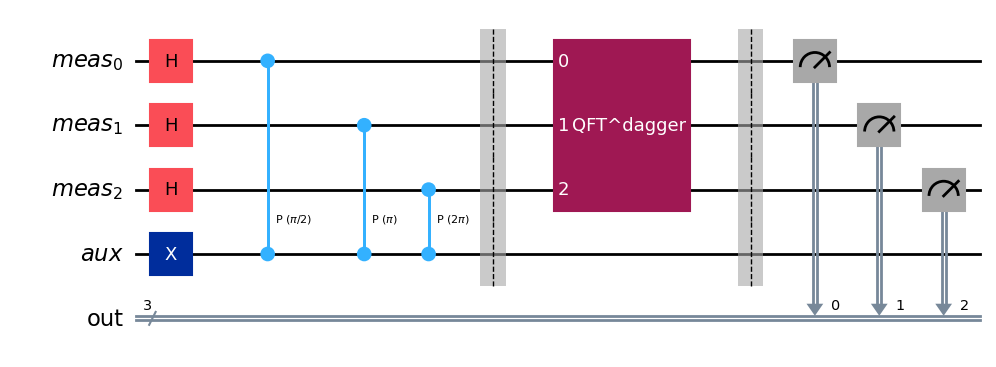

In [31]:
def qft_dagger(qreg):
    """逆量子フーリエ変換用の回路"""
    qc = QuantumCircuit(qreg)

    ##################
    ### EDIT BELOW ###
    ##################

    for j in range(qreg.size // 2):
        qc.swap(qreg[j], qreg[-1 - j])

    for itarg in range(qreg.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1
            qc.cp(-2. * np.pi * (2 ** power), ictrl, itarg)

        qc.h(itarg)

    ##################
    ### EDIT ABOVE ###
    ##################

    qc.name = "QFT^dagger"
    return qc
qc.barrier()
qc.append(qft_dagger(qreg_meas), qargs=qreg_meas)
qc.barrier()
qc.measure(qreg_meas, creg_meas)
qc.draw('mpl')

シミュレータでの実験

In [32]:
from qiskit.primitives import StatevectorSampler

# Instantiate a new Sampler object
sampler = StatevectorSampler()

# Now run the job and examine the results
sampler_job = sampler.run([qc])
result = sampler_job.result()

from qiskit.visualization import plot_distribution
plt.style.use('dark_background')
plot_distribution(result.quasi_dists[0])

AttributeError: 'PrimitiveResult' object has no attribute 'quasi_dists'

In [33]:
from qiskit_ibm_runtime import Sampler, QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit.visualization import plot_distribution
import matplotlib.pyplot as plt

# 1. IBM Quantumアカウントの詳細を保存します（一度だけ実行）
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="YOUR_IBM_QUANTUM_TOKEN",
#                                  instance="ibm-q/open/main") # またはご自身のインスタンス

# 2. サービスを初期化します（アカウントを保存済みの場合）
service = QiskitRuntimeService()

# 3. バックエンドを選択します
# より適切なクラウドシミュレータの例
# 利用可能なシミュレータ名は service.backends() で確認してください
backend = service.get_backend("simulator_statevector") # 例: IBM Cloud上のシミュレータ

# バックエンドを指定してSamplerオブジェクトを初期化します
sampler = Sampler(backend=backend)

# デモンストレーション用のシンプルな量子回路を作成します
qc = QuantumCircuit(1)
qc.h(0)
qc.measure_all()

# ジョブを実行し、結果を確認します
sampler_job = sampler.run(qc)
result = sampler_job.result()

# 分布をプロットします
plt.style.use('dark_background')
plot_distribution(result.quasi_dists[0])
plt.show()

AccountNotFoundError: 'Unable to find account.'

量子コンピュータでの実験

In [34]:
# 最も空いているバックエンドで回路を実行します。キュー内のジョブの実行をモニターします。
qc_tr = transpile(qc, backend=backend, optimization_level=3)

from qiskit_ibm_runtime import Sampler, Session
# create a Runtime session for efficient execution (optional)
session = Session(service=service, backend=backend)
sampler = Sampler(session=session)
job = sampler.run(qc)

NameError: name 'backend' is not defined

In [35]:
# 計算結果
result = job.result()
plot_distribution(result.quasi_dists[0])

NameError: name 'job' is not defined

位数の発見

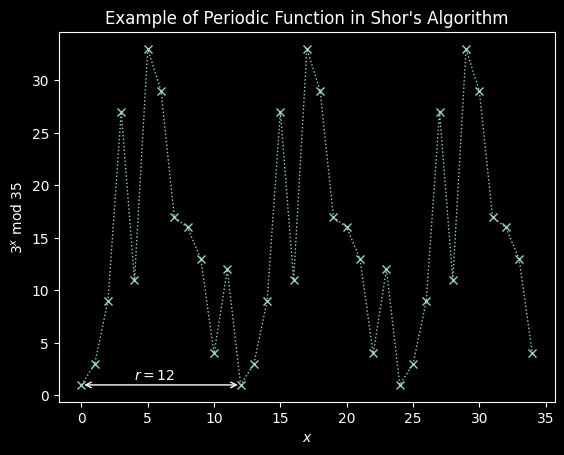

In [36]:
N = 35
a = 3

# プロットするデータを計算する
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# matplotlibを使って描画
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod {N}',
       title="Example of Periodic Function in Shor's Algorithm")

try: # グラフ上にrをプロット
    r = yvals[1:].index(1) + 1
except ValueError:
    print('Could not find period, check a < N and have no common factors.')
else:
    plt.annotate(text='', xy=(0, 1), xytext=(r, 1), arrowprops={'arrowstyle': '<->'})
    plt.annotate(text=f'$r={r}$', xy=(r / 3, 1.5))

オラクルの実装

In [39]:
def c_amod15(a, l):
    """mod 15による制御ゲート"""

    if a not in [2, 4, 7, 8, 11, 13]:
        raise ValueError("'a' must be 2, 4, 7, 8, 11, or 13")

    U = QuantumCircuit(4)

    ##################
    ### EDIT BELOW ###
    ##################

    if a in [2, 13]:
        # 下の位を上に移すので、上の位から順にSWAPしていく
        U.swap(3, 2)
        U.swap(2, 1)
        U.swap(1, 0)
    elif a in [4, 11]:
        # 「一つ飛ばし」のビットシフト
        U.swap(3, 1)
        U.swap(2, 0)
    elif a in [8, 7]:
        # 下から順
        U.swap(1, 0)
        U.swap(2, 1)
        U.swap(3, 2)

    if a in [7, 11, 13]:
        U.x([0, 1, 2, 3])

    ##################
    ### EDIT ABOVE ###
    ##################
    # Uを2^l回繰り返す
    U_power = U.repeat(2 ** l)

    # U_powerをゲートに変換
    gate = U_power.to_gate()
    gate.name = f"{a}^{2 ** l} mod 15"

    # gateを制御ゲートに変換
    c_gate = gate.control()
    return c_gate

回路全体の実装

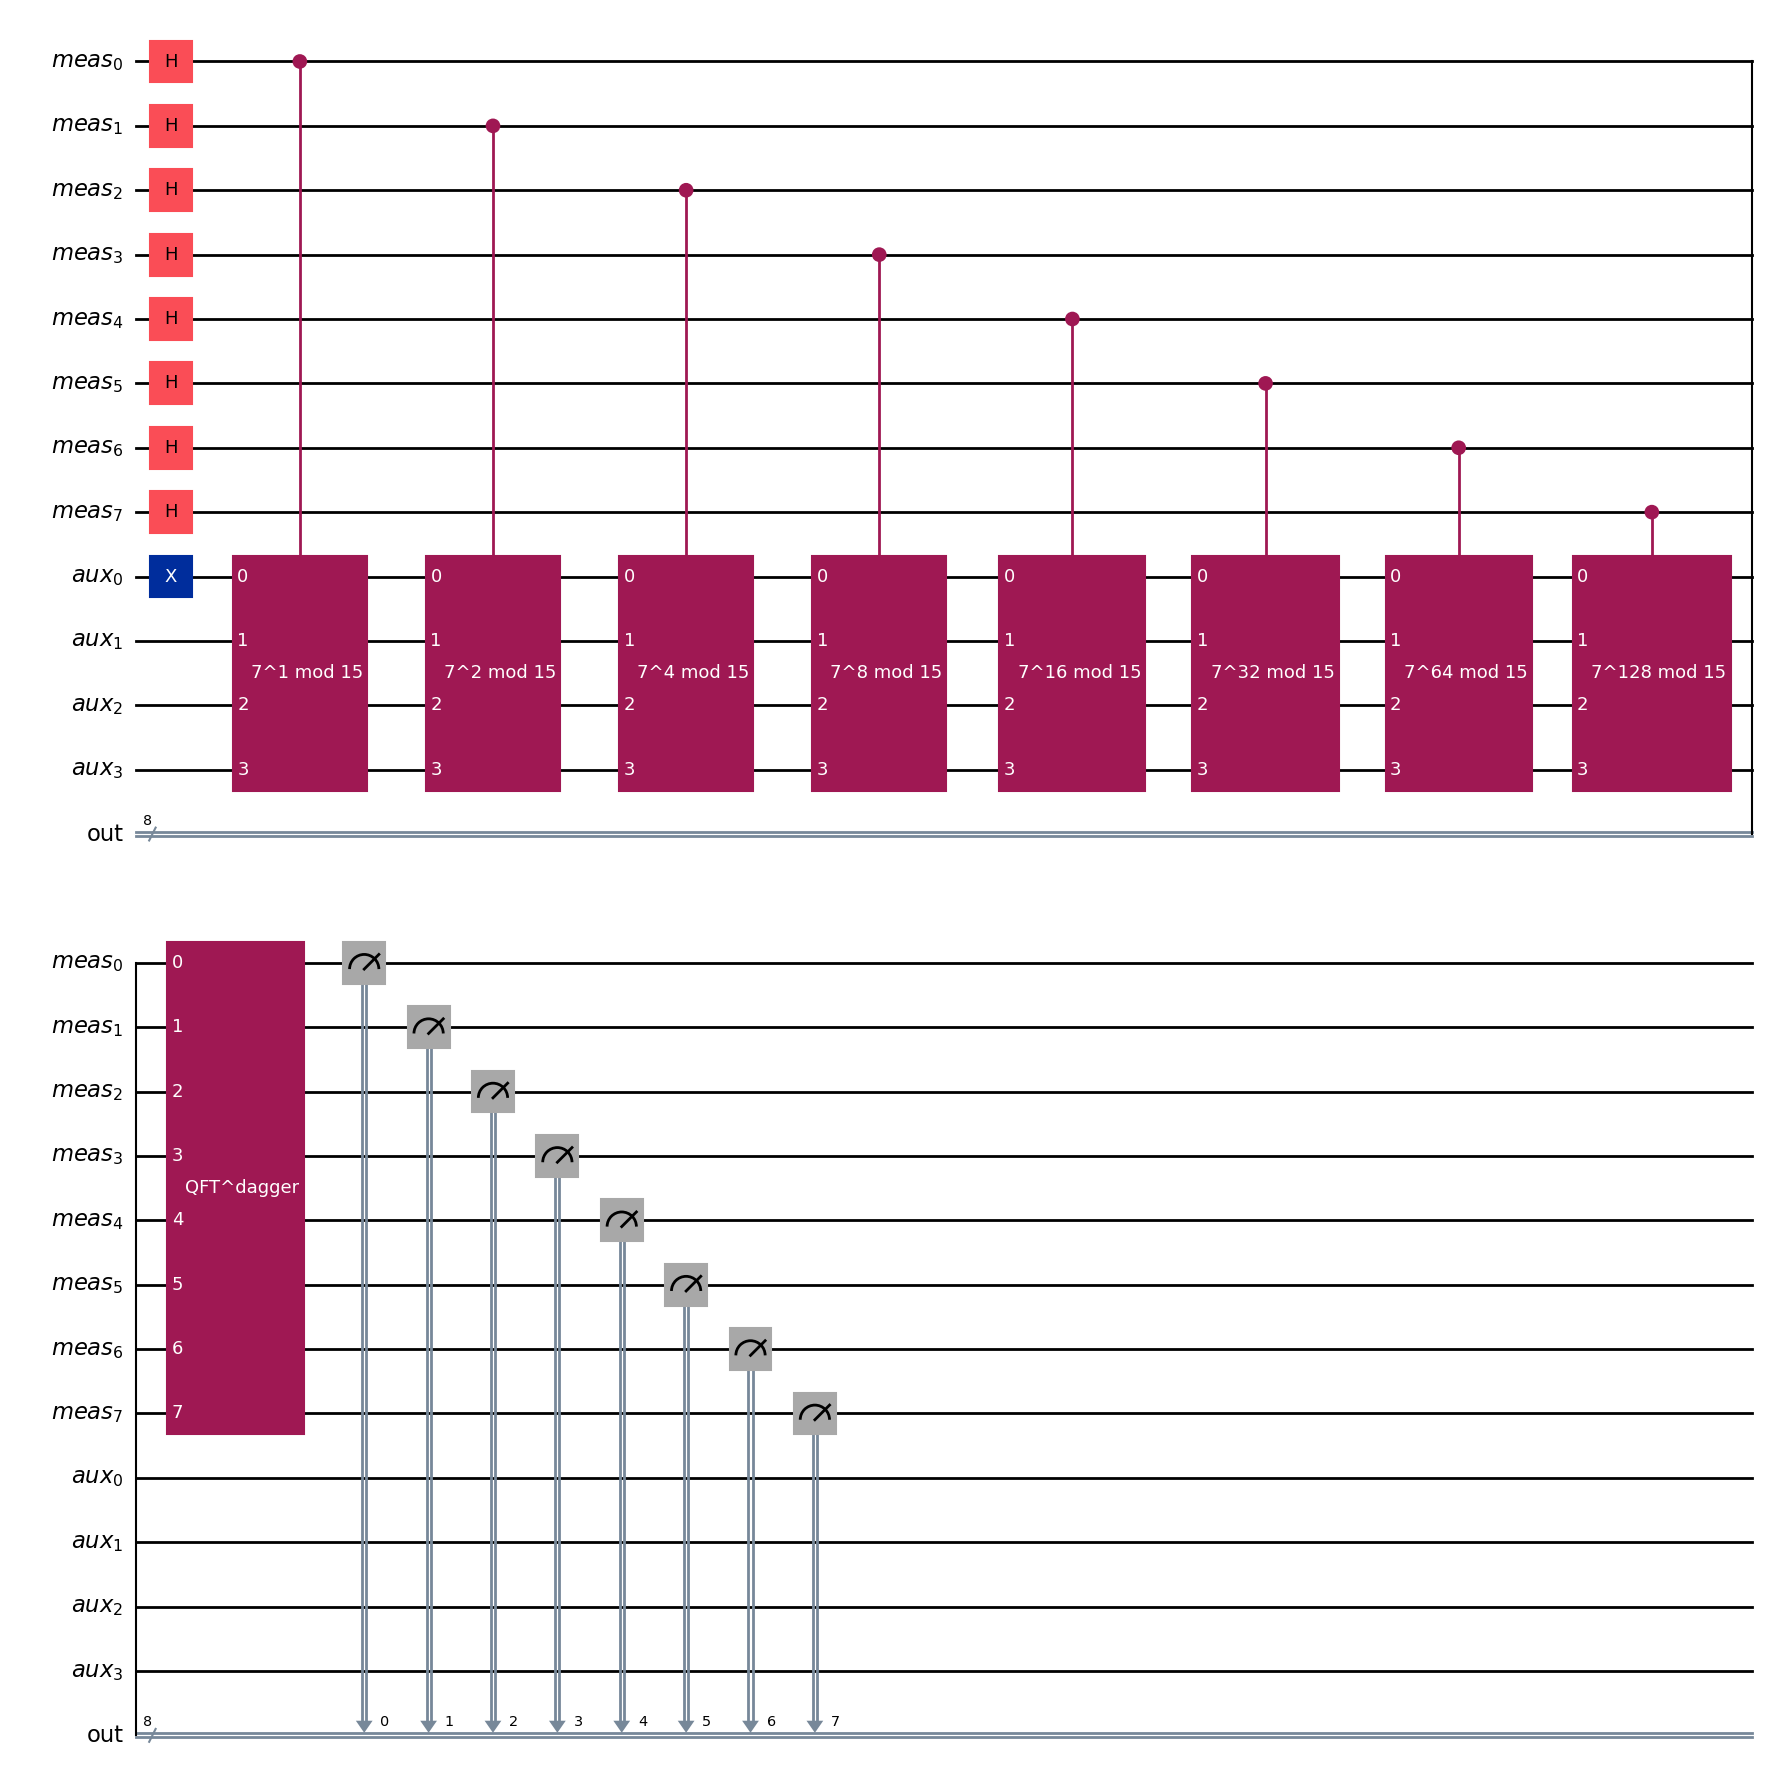

In [40]:
# 15と互いに素な数
a = 7

# 測定用ビットの数（位相推定の精度）
n_meas = 8

# 位相測定用のレジスタ
qreg_meas = QuantumRegister(n_meas, name='meas')
# Uを作用させる作業用レジスタ
qreg_aux = QuantumRegister(4, name='aux')
# 位相測定の結果が書き出される古典レジスタ
creg_meas = ClassicalRegister(n_meas, name='out')

# 2つの量子レジスタと1つの古典レジスタから量子回路を作る
qc = QuantumCircuit(qreg_meas, qreg_aux, creg_meas)

# 測定用レジスタをequal superpositionに初期化
qc.h(qreg_meas)
# 作業用レジスタを|1>に初期化
qc.x(qreg_aux[0])

# 制御Uゲートを適用
for l, ctrl in enumerate(qreg_meas):
    qc.append(c_amod15(a, l), qargs=([ctrl] + qreg_aux[:]))

# 逆QFTを適用
qc.append(qft_dagger(qreg_meas), qargs=qreg_meas)

# 回路を測定
qc.measure(qreg_meas, creg_meas)
qc.draw('mpl')

In [41]:
shots = 10000

# Instantiate a new Sampler object
from qiskit.primitives import Sampler
sampler = Sampler()

# Now run the job and examine the results
sampler_job = sampler.run(qc)
answer = sampler_job.result().quasi_dists[0]

from qiskit.visualization import plot_distribution
plt.style.use('dark_background')
plot_distribution(answer)

ImportError: cannot import name 'Sampler' from 'qiskit.primitives' (c:\Users\batsman\jupyter_qiskit\qiskit_server\lib\site-packages\qiskit\primitives\__init__.py)

計算結果の解析

In [42]:
rows, measured_phases = [], []
for output in answer:
    phase = output / (2 ** n_meas)
    measured_phases.append(phase)
    # これらの値をテーブルの行に追加：
    rows.append(f"{output:3d}      {output:3d}/{2 ** n_meas} = {phase:.3f}")

# 結果を表示
print('Register Output    Phase')
print('------------------------')

for row in rows:
    print(row)

NameError: name 'answer' is not defined

In [43]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append(f'{phase:10.3f}      {frac.numerator:2d}/{frac.denominator:2d} {frac.denominator:13d}')

# 結果を表示
print('     Phase   Fraction   Guess for r')
print('-------------------------------------')

for row in rows:
    print(row)

     Phase   Fraction   Guess for r
-------------------------------------
